# Determining the effectiveness a campaign to promote the loyalty programme

## Steps

* Introduction
* Descriptive data analysis
* Analysing the promotional campaign and enrollments
* Demography vs promotional campaign
* Flight activity vs Promotional campaign
* Loyalty membership cancellations - prediction
* Insights



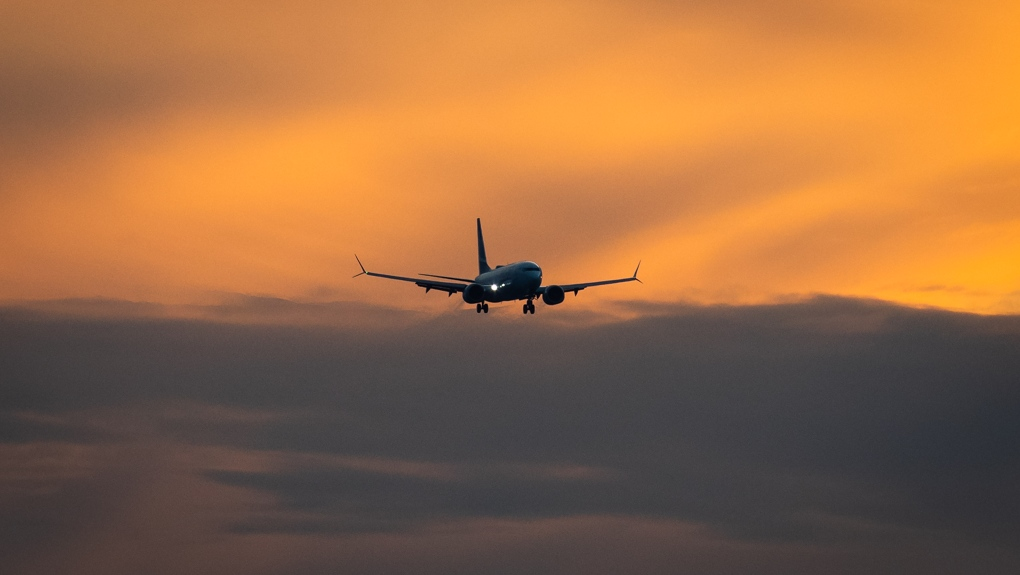

## Introduction

**Scenario:** The airline implemented a promotional campaign, aimed at enhancing program enrollment. The dataset encompasses information regarding the signups, enrollment, cancellations within the loyalty program, and supplementary customer demographics.

**Research Questions:** To determine the effectiveness of the promotional campaign of the loyalaty programme:

* Did the number of memberships increase as a result of the promotional campaign?
* Did the number of bookings increase as a result of the promotional campaign?
* Demographic information of loyalty members.
* Can we predict the churn risk of loyalty members?

**Data Set:** The dataset was obtained from Kaggle. https://www.kaggle.com/datasets/agungpambudi/airline-loyalty-campaign-program-impact-on-flights?select=Customer+Flight+Activity.csv

There are 2 csv files.

* Customer Flight Activity.csv

| Field |	Description |
|:--------|:--------|
| Loyalty Number	| Customer's unique loyalty number |
| Year	| Year of the period |
| Month	| Month of the period |
| Flights Booked	| Number of flights booked for member only in the period |
| Flights with Companions	| Number of flights booked with additional passengers in the period |
| Total Flights	| Sum of Flights Booked and Flights with Companions |
| Distance	| Flight distance traveled in the period (km) |
| Points Accumulated	| Loyalty points accumulated in the period |
| Points Redeemed	| Loyalty points redeemed in the period |
| Dollar Cost Points Redeemed	| Dollar equivalent for points redeemed in the period in CDN |

* Customer Loyalty History.csv

| Field	| Description |
|:--------|:--------|
| Loyalty Number	| Customer's unique loyalty number |
| Country	| Country of residence |
| Province	| Province of residence |
| City	| City of residence |
| Postal Code	| Postal code of residence |
| Gender	| Gender |
| Education	| Highest education level (High school or lower > College > Bachelor > Master > Doctor) |
| Salary	| Annual income |
| Marital Status	| Marital status (Single, Married, Divorced) |
| Loyalty Card	| Loyalty card status (Star > Nova > Aurora) |
| CLV	| Customer lifetime value - total invoice value for all flights ever booked by member |
| Enrollment Type	| Enrollment type (Standard / 2018 Promotion) |
| Enrollment Year	| Year Member enrolled in membership program |
| Enrollment Month	| Month Member enrolled in membership program |
| Cancellation Year	| Year Member cancelled their membership |
| Cancellation Month	| Month Member cancelled their membership |

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pywaffle import Waffle
from scipy.stats import zscore
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# avoiding display of truncated columns 
pd.options.display.max_columns = 140
pd.options.display.max_colwidth = 50

## Descriptive data analysis

### Load the data

In [2]:
customer_history = pd.read_csv('Customer Loyalty History.csv')
flight_bookings = pd.read_csv('Customer Flight Activity.csv')

### Data types

In [3]:
customer_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [4]:
flight_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


*Notes:* 
* *Data looks clean.*
* *Variables with null values: `Salary`, `Cancellation Year` and `Cancellation Month`*


### Summary statistics

In [5]:
customer_history.describe()

,Loyalty Number,Salary,CLV,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
count,16737.000000,12499.000000,16737.000000,16737.000000,16737.000000,2067.000000,2067.000000
mean,549735.880445,79245.609409,7988.896536,2015.253211,6.669116,2016.503145,6.962748
std,258912.132453,35008.297285,6860.982280,1.979111,3.398958,1.380743,3.455297
min,100018.000000,-58486.000000,1898.010000,2012.000000,1.000000,2013.000000,1.000000
25%,326603.000000,59246.500000,3980.840000,2014.000000,4.000000,2016.000000,4.000000
50%,550434.000000,73455.000000,5780.180000,2015.000000,7.000000,2017.000000,7.000000
75%,772019.000000,88517.500000,8940.580000,2017.000000,10.000000,2018.000000,10.000000
max,999986.000000,407228.000000,83325.380000,2018.000000,12.000000,2018.000000,12.000000


In [6]:
flight_bookings.describe()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
count,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000
mean,550037.873084,2017.500000,6.500000,4.115052,1.031805,5.146858,1208.880059,123.692721,30.696872,2.484503
std,258935.286969,0.500001,3.452057,5.225518,2.076869,6.521227,1433.155320,146.599831,125.486049,10.150038
min,100018.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326961.000000,2017.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550834.000000,2017.500000,6.500000,1.000000,0.000000,1.000000,488.000000,50.000000,0.000000,0.000000
75%,772194.000000,2018.000000,9.250000,8.000000,1.000000,10.000000,2336.000000,239.000000,0.000000,0.000000
max,999986.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


*Notes:*
* *`CLV` (Customer lifetime value), `Salary` and flight activity related variables (`Flights Booked`, `Flights with Companions`, `Total Flights`,	`Distance`,	`Points Accumulated`,	`Points Redeemed`,	`Dollar Cost Points Redeemed`) are positively skewed. (Mean > Median)*
* *Both most entrollments and cancellations occur in July*
* *Most of the customers had enrolled in 2015*

In [7]:
customer_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [8]:
#A function to get unique values from object type columns

def get_unique_values(dataframe):
    unique_values_dict = {}

    # Iterate through each column
    for column in dataframe.columns:
        # Check if the column has object type
        if dataframe[column].dtype == 'O':
            # Get unique values for the object-type column
            unique_values = dataframe[column].unique()
            unique_values_dict[column] = unique_values

    return unique_values_dict

In [9]:
unique_values_customer_history = get_unique_values(customer_history)

# Print the unique values for each object-type column
for column, unique_values in unique_values_customer_history.items():
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Country': ['Canada']
Unique values in 'Province': ['Ontario' 'Alberta' 'British Columbia' 'Quebec' 'Yukon' 'New Brunswick'
 'Manitoba' 'Nova Scotia' 'Saskatchewan' 'Newfoundland'
 'Prince Edward Island']
Unique values in 'City': ['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Whitehorse' 'Trenton' 'Montreal'
 'Dawson Creek' 'Quebec City' 'Fredericton' 'Ottawa' 'Tremblant' 'Calgary'
 'Thunder Bay' 'Whistler' 'Peace River' 'Winnipeg' 'Sudbury'
 'West Vancouver' 'Halifax' 'London' 'Regina' 'Kelowna' "St. John's"
 'Victoria' 'Kingston' 'Banff' 'Moncton' 'Charlottetown']
Unique values in 'Postal Code': ['M2Z 4K1' 'T3G 6Y6' 'V6E 3D9' 'P1W 1K4' 'J8Y 3Z5' 'Y2K 6R0' 'P5S 6R4'
 'K8V 4B2' 'H2Y 2W2' 'M8Y 4K8' 'U5I 4F1' 'G1B 3L5' 'H4G 3T4' 'M2M 7K8'
 'M2M 6J7' 'E3B 2H2' 'M1R 4K3' 'T9G 1W3' 'H2Y 4R4' 'V5R 1W3' 'P1L 8X8'
 'K1F 2R2' 'H5Y 2S9' 'V1E 4R6' 'H2T 2J6' 'T3E 2V9' 'H2T 9K8' 'K8T 5M5'
 'V6T 1Y8' 'P2T 6G3' 'T9O 2W2' 'V6E 3Z3' 'R6Y 4T5' 'M5V 1G5' 'V6V 8Z3'
 'B3J 9S2' 'M5B 3E4' 'R2C 0M

#### Feature engineering

##### Enrolment date
*The `Enrollment Date` is currently indicated seperately using year and month. The new variable combines the two and create the date as the first of the month.*

In [10]:
customer_history['Enrollment Date'] = pd.to_datetime(
    customer_history['Enrollment Year'].astype(str) + '-' + 
    customer_history['Enrollment Month'].astype(str) + '-01'
)

##### Cancellation date
*Same as `Enrollment date`, this combines `Cancellation Year` and `Cancellation Month`.*

In [11]:
customer_history['Cancellation Year'] = customer_history['Cancellation Year'].astype('Int64')  # Convert to nullable integer
customer_history['Cancellation Month'] = customer_history['Cancellation Month'].astype('Int64')  # Convert to nullable integer

In [12]:
customer_history['Cancellation Date'] = pd.to_datetime(
    customer_history['Cancellation Year'].astype(str) + '-' + 
    customer_history['Cancellation Month'].astype(str) + '-01',
    errors='coerce'
)

In [13]:
customer_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,<NA>,<NA>,2016-02-01,NaT
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,<NA>,<NA>,2016-03-01,NaT
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018,1,2014-07-01,2018-01-01
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,<NA>,<NA>,2013-02-01,NaT
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,<NA>,<NA>,2014-10-01,NaT


##### Loyalty Period
*The `Current Status` variable indicates if the person is a current member (0) or has cancelled the membership (1)* 
*The number of months the customer has hold the loyalty membership. Calculated as `Cancellation Date` - `Enrollment Date`.*
*For current members the length of loyalty is calculated using 2019-1-1 as the `Reference Date`.*

In [14]:
customer_history['Current Status'] = np.where(customer_history['Cancellation Year'].notnull(), 1, 0)

In [15]:
# Set default cancellation date for NaT values
Reference_Date = pd.to_datetime('2019-01-01')

# Fill NaN values in 'Cancellation Date' with the default cancellation date
customer_history['Cancellation Date'].fillna(Reference_Date, inplace=True)

# Calculate loyalty period in months
customer_history['Loyalty Period (Months)'] = (
    customer_history['Cancellation Date'] - customer_history['Enrollment Date']
).dt.days.div(30, fill_value=0).astype(int)


In [16]:
customer_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Current Status,Loyalty Period (Months)
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,<NA>,<NA>,2016-02-01,2019-01-01,0,35
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,<NA>,<NA>,2016-03-01,2019-01-01,0,34
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018,1,2014-07-01,2018-01-01,1,42
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,<NA>,<NA>,2013-02-01,2019-01-01,0,72
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,<NA>,<NA>,2014-10-01,2019-01-01,0,51


How long has the members been with the airline before cancelling the loyalty membership

In [17]:
length = customer_history.groupby(['Loyalty Period (Months)']).agg({'Current Status': 'mean'}).sort_values(by='Current Status', ascending=False)

length.head(10)

,Current Status
Loyalty Period (Months),
0,1.000000
8,0.814297
13,0.158974
5,0.132000
16,0.127962
3,0.123967
7,0.121311
12,0.119565
1,0.118519


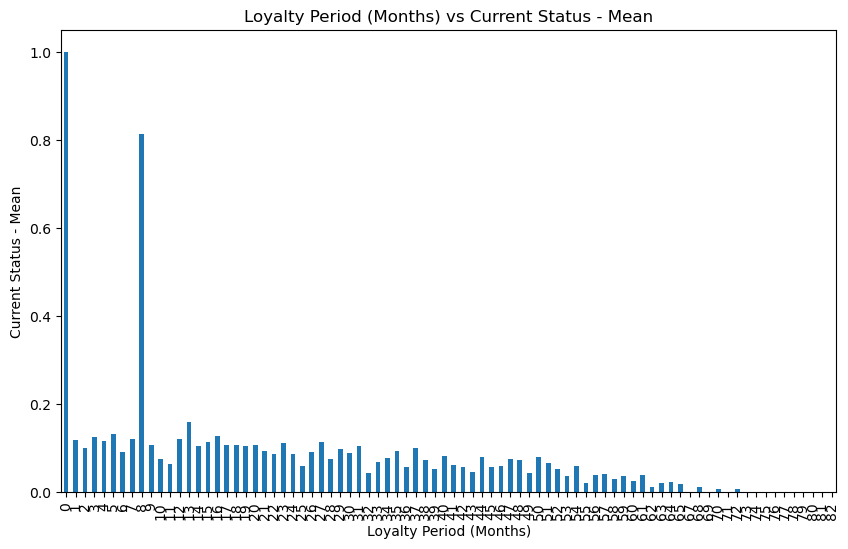

In [18]:
length = customer_history.groupby(['Loyalty Period (Months)']).agg({'Current Status': 'mean'}).sort_index()


# Plotting the bar chart
length.plot(kind='bar', y='Current Status', figsize=(10, 6), legend=False)
plt.title('Loyalty Period (Months) vs Current Status - Mean')
plt.xlabel('Loyalty Period (Months)')
plt.ylabel('Current Status - Mean')
plt.show()

**Notes:**
* Most customers have cancelled the loyalty membership less than one month of joining and after 8 months. 
* Cancelling the membership after a year is low.

### Promotional campaign

##### Number of new enrollments during the promotion period

In [19]:
customer_history['Enrollment Year'] = customer_history['Enrollment Year'].astype(str)


In [20]:
customer_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Loyalty Number           16737 non-null  int64         
 1   Country                  16737 non-null  object        
 2   Province                 16737 non-null  object        
 3   City                     16737 non-null  object        
 4   Postal Code              16737 non-null  object        
 5   Gender                   16737 non-null  object        
 6   Education                16737 non-null  object        
 7   Salary                   12499 non-null  float64       
 8   Marital Status           16737 non-null  object        
 9   Loyalty Card             16737 non-null  object        
 10  CLV                      16737 non-null  float64       
 11  Enrollment Type          16737 non-null  object        
 12  Enrollment Year          16737 n

In [21]:
level_counts = customer_history.groupby(['Enrollment Type', 'Enrollment Year'])['Loyalty Number'].nunique()


new_enrollments = level_counts.reset_index()
new_enrollments.columns = ['Enrollment Type', 'Enrollment Year','Number of Enrollments']

# Sort by 'Year' and then by 'Type'
new_enrollments.sort_values(by=['Enrollment Year', 'Enrollment Type'], inplace=True)

print(new_enrollments)

  Enrollment Type Enrollment Year  Number of Enrollments
1        Standard            2012                   1686
2        Standard            2013                   2397
3        Standard            2014                   2370
4        Standard            2015                   2331
5        Standard            2016                   2456
6        Standard            2017                   2487
0  2018 Promotion            2018                    971
7        Standard            2018                   2039


###### Number of memberships cancelled during the period

In [22]:
# Filter rows within the promotion period
cancellations_during_promotion = customer_history[(customer_history['Cancellation Date'] >= '2018-02-01') & (customer_history['Cancellation Date'] <= '2018-04-01')]

# Count the number of unique IDs in the filtered data
num_cancelled = cancellations_during_promotion['Loyalty Number'].nunique()

print(f"Number of memberships cancelled during promotional campaign: {num_cancelled}")

Number of memberships cancelled during promotional campaign: 141


##### Net memebership gain during the promotional campaign

In [23]:
# Filter rows of 2018 Promotional campaign enrollments
enroll_2018 = new_enrollments[new_enrollments['Enrollment Type'] == '2018 Promotion']

# Sum the counts for enrollments
enroll_2018_promo = enroll_2018['Number of Enrollments'].sum()

net_memberships = enroll_2018_promo - num_cancelled

print(f"Net gain of memberships during promotional campaign: {net_memberships}")

Net gain of memberships during promotional campaign: 830


**Note:**
* The cancellations are based on the performance of the loyalty programme and therefore are not directly related to promotional campaign. 
* Therefore, we can only think of the Gross Enrollments which is 971 calculated above

##### Calculate Promotion period

In [24]:
# Filter rows where 'Enrollment Type' is '2018 Promotion'
data_2018_Promotion = customer_history[customer_history['Enrollment Type'] == '2018 Promotion']

# Find the minimum and maximum dates for 'Variable' B
min_date_2018 = data_2018_Promotion['Enrollment Date'].min()
max_date_2018 = data_2018_Promotion['Enrollment Date'].max()

print(f"Start Date for 2018 Promotion: {min_date_2018}")
print(f"End Date for 2018 Promotion: {max_date_2018}")

# Calculate the duration
duration_promotion = max_date_2018 - min_date_2018
print(f"Duration for 2018 Promotion: {duration_promotion}")

Start Date for 2018 Promotion: 2018-02-01 00:00:00
End Date for 2018 Promotion: 2018-04-01 00:00:00
Duration for 2018 Promotion: 59 days 00:00:00


**Notes:**

* Assume the campaign ran from Feb 2018 - April 2018.

##### Plot changes in enrolment numbers over months in different years

In [25]:
def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram for cancelled and current memberships
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Current": dataframe[dataframe["Current Status"]==0][column],
    "Cancelled":dataframe[dataframe["Current Status"]==1][column]})
    # Plot the histogram
    temp[["Current","Cancelled"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

In [26]:
enroll_counts_plot = customer_history.groupby(['Enrollment Type', 'Enrollment Year', 'Enrollment Month'])['Loyalty Number'].nunique()


enroll_plot = enroll_counts_plot.reset_index()
enroll_plot.columns = ['Enrollment Type', 'Year','Month', 'Number of Enrollments']

# Sort by 'Year' and then by 'Type'
enroll_plot.sort_values(by=['Year', 'Month', 'Enrollment Type'], inplace=True)

print(enroll_plot)

   Enrollment Type  Year  Month  Number of Enrollments
3         Standard  2012      4                     62
4         Standard  2012      5                    203
5         Standard  2012      6                    195
6         Standard  2012      7                    213
7         Standard  2012      8                    206
..             ...   ...    ...                    ...
76        Standard  2018      8                    218
77        Standard  2018      9                    185
78        Standard  2018     10                    213
79        Standard  2018     11                    246
80        Standard  2018     12                    238

[81 rows x 4 columns]


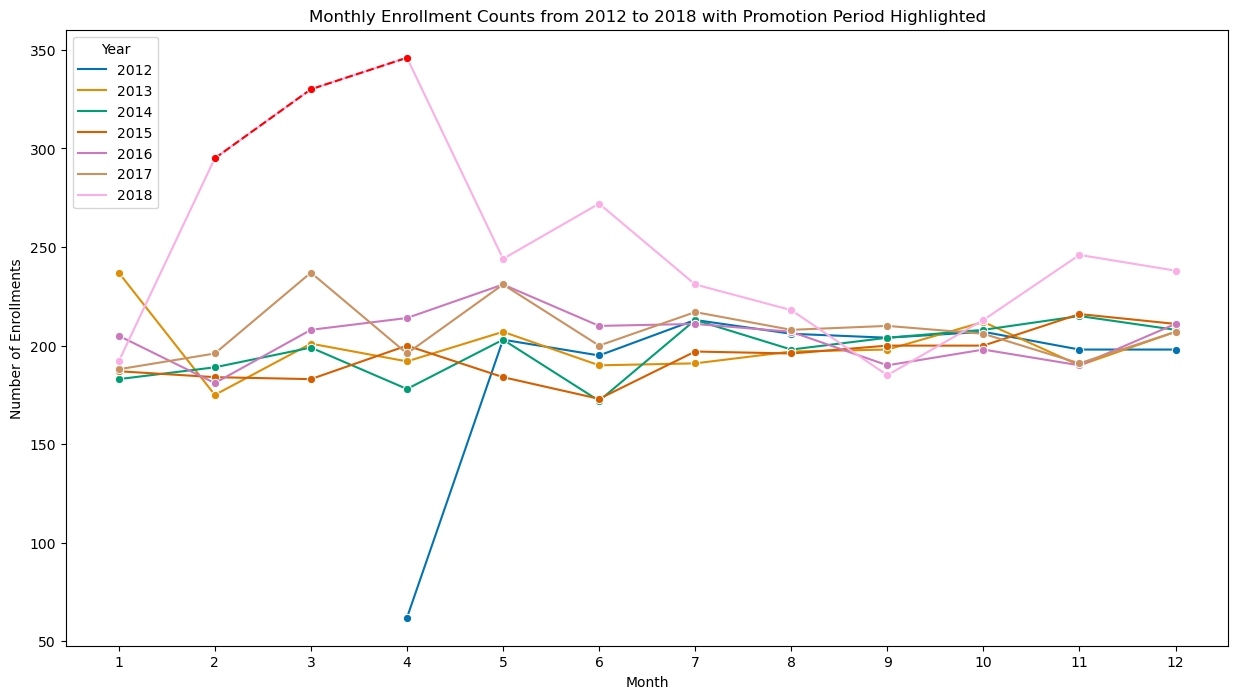

In [27]:
# Setting a colorblind-friendly palette for plotting
sns.set_palette("colorblind")

# Plotting enrollments for all years with the promotion period highlighted
plt.figure(figsize=(15, 8))

# Plot all lines
sns.lineplot(data=enroll_plot, x='Month', y='Number of Enrollments', hue='Year', marker='o')

# Highlight promotion period
promotion_period = enroll_plot[enroll_plot['Enrollment Type'] == '2018 Promotion']
sns.lineplot(data=promotion_period, x='Month', y='Number of Enrollments', color='red', marker='o', linestyle='--')

plt.title('Monthly Enrollment Counts from 2012 to 2018 with Promotion Period Highlighted')
plt.xlabel('Month')
plt.ylabel('Number of Enrollments')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left')
plt.show()


**Notes:**
* The promotional camplain clearly has increased the number of enrollments for the months February, March and April in 2018 than previous years. 

### Demographic vs Promotional Campaign

In [28]:
def create_stacked_bar_plots(data, variable_names):
    """
    Create stacked bar plots for the count of individuals based on 'Variable' levels.

    Parameters:
    - data: DataFrame
        The input DataFrame containing the data.
    - variable_names: list
        A list of selected column names for which stacked bar plots will be created.

    Returns:
    - None
        Displays the stacked bar plots.
    """
    # Setting a color palette
    sns.set_palette("colorblind")

    # Loop through each variable and create a stacked bar plot
    for variable in variable_names:
        plt.figure(figsize=(10, 6))
        pd.crosstab(data[variable], data['Enrollment Type']).plot(kind='bar', stacked=True, color=sns.color_palette("colorblind"), edgecolor='white')

        # Generate title based on the variable name
        title = f'Stacked Bar Plot for Count of Individuals by {variable.capitalize()} and Enrollment Type Levels'

        plt.title(title)
        plt.xlabel(variable.capitalize())  # Capitalize the variable name in the x-axis label
        plt.ylabel('Count of Individuals')
        plt.legend(title='Enrollment Type', loc='upper right')
        plt.show()

# Sample Usage
# Assuming 'customer_history' is your DataFrame and 'Enrollment Type' is the column with levels A and B



<Figure size 1000x600 with 0 Axes>

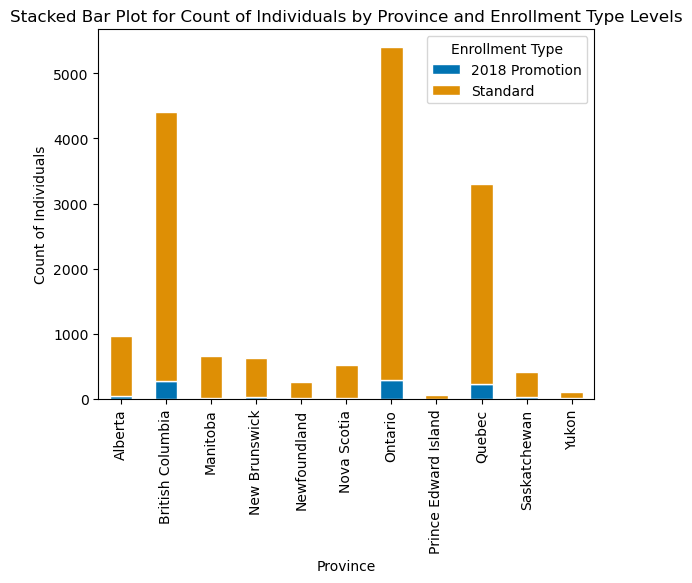

<Figure size 1000x600 with 0 Axes>

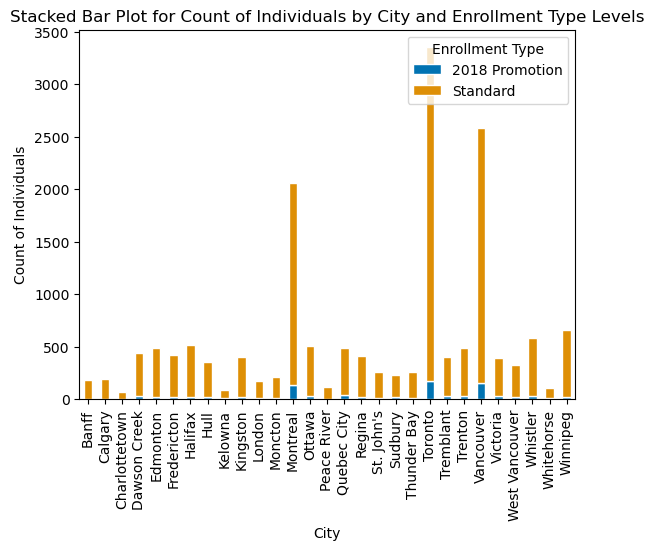

<Figure size 1000x600 with 0 Axes>

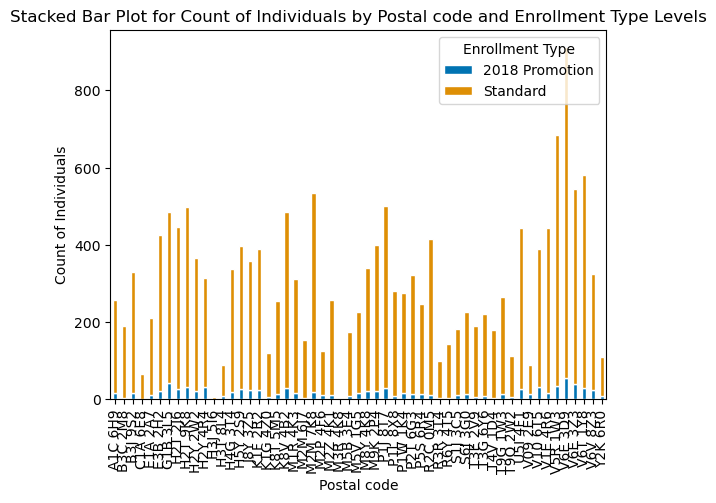

<Figure size 1000x600 with 0 Axes>

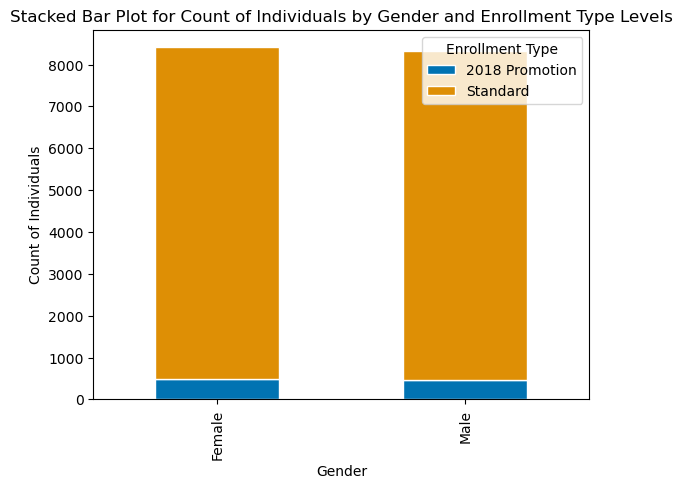

<Figure size 1000x600 with 0 Axes>

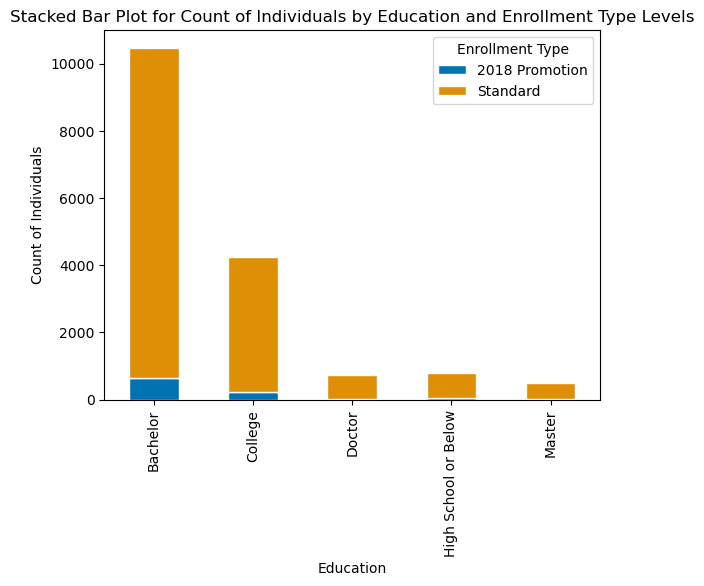

<Figure size 1000x600 with 0 Axes>

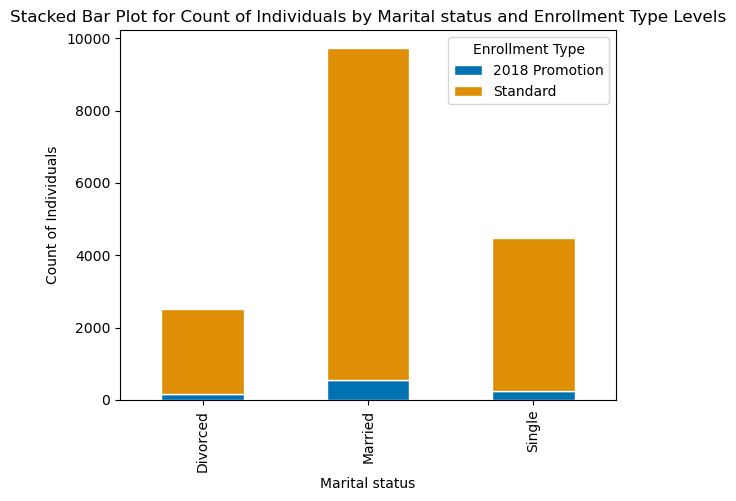

<Figure size 1000x600 with 0 Axes>

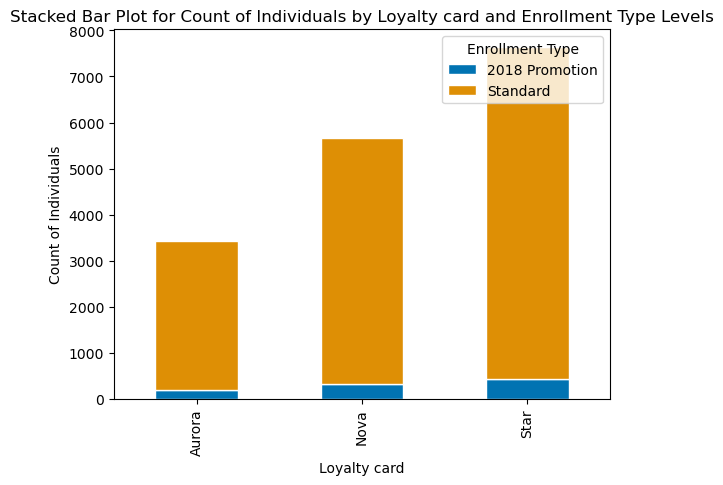

In [29]:
variable_names_list = ['Province', 'City', 'Postal Code', 'Gender', 'Education', 'Marital Status', 'Loyalty Card']  
create_stacked_bar_plots(customer_history, variable_names_list)

**Notes:**
* Overall Ontario, British columbia and Quebec have higher enrollments and the promotional campaign seems to be effective only in these provinces too.
* Out of the cities Toronto, Vancouver, Montreal have higher enrollments and the promotional campaign has encouraged people in the said three cities to join the leadership programme including the cities Ottawa, Quebec City, Tremblant, Trenton, Victoria and Whistler
* Promotional campaign has reached both genders.
* Promotional campaign has reached people with a Bachelors and Collage degrees aligning with the current highest enrollments.
* Promotional campaign has reached all levels of Maritel status and loyalty card options similar to current enrollments.

### Flight activity during summer vs promotional campaign

#### Feature engineering

##### Flight date
*The `Flight Date` is currently indicated seperately using year and month. The new variable combines the two and create the date as the first of the month.*

In [30]:
flight_bookings['Flight Date'] = pd.to_datetime(
    flight_bookings['Year'].astype(str) + '-' + 
    flight_bookings['Month'].astype(str) + '-01'
)

In [31]:
flight_bookings['Promotion'] = 'Standard'  # Initialize with 'YYY'

# Conditionally set '2018 Promotion' for rows where 'Flight Date' is between '2018-6-1' and '2018-8-1'
flight_bookings.loc[
    (flight_bookings['Flight Date'] >= '2018-06-01') & (flight_bookings['Flight Date'] <= '2018-08-01'),
    'Promotion'
] = '2018 Promotion'


In [32]:
flight_bookings

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Flight Date,Promotion
0,100018,2017,1,3,0,3,1521,152.0,0,0,2017-01-01,Standard
1,100102,2017,1,10,4,14,2030,203.0,0,0,2017-01-01,Standard
2,100140,2017,1,6,0,6,1200,120.0,0,0,2017-01-01,Standard
3,100214,2017,1,0,0,0,0,0.0,0,0,2017-01-01,Standard
4,100272,2017,1,0,0,0,0,0.0,0,0,2017-01-01,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...
405619,999902,2018,12,0,0,0,0,0.0,0,0,2018-12-01,Standard
405620,999911,2018,12,0,0,0,0,0.0,0,0,2018-12-01,Standard
405621,999940,2018,12,3,0,3,1233,123.0,0,0,2018-12-01,Standard
405622,999982,2018,12,0,0,0,0,0.0,0,0,2018-12-01,Standard


In [33]:
flight_bookings['Promotion'].unique()

array(['Standard', '2018 Promotion'], dtype=object)

In [34]:
flights_booked_counts_plot = flight_bookings.groupby(['Year', 'Month','Promotion'])['Flights Booked'].sum()


flights_booked_plot = flights_booked_counts_plot.reset_index()
flights_booked_plot.columns = ['Year','Month', 'Promotion','Number of Flights per month']

# Sort by 'Year' and then by 'Type'
flights_booked_plot.sort_values(by=['Year', 'Month', 'Promotion'], inplace=True)

print(flights_booked_plot)

    Year  Month       Promotion  Number of Flights per month
0   2017      1        Standard                        47766
1   2017      2        Standard                        47691
2   2017      3        Standard                        64271
3   2017      4        Standard                        55720
4   2017      5        Standard                        65279
5   2017      6        Standard                        80493
6   2017      7        Standard                        89288
7   2017      8        Standard                        78692
8   2017      9        Standard                        63304
9   2017     10        Standard                        60351
10  2017     11        Standard                        56905
11  2017     12        Standard                        77650
12  2018      1        Standard                        49170
13  2018      2        Standard                        48643
14  2018      3        Standard                        66928
15  2018      4        S

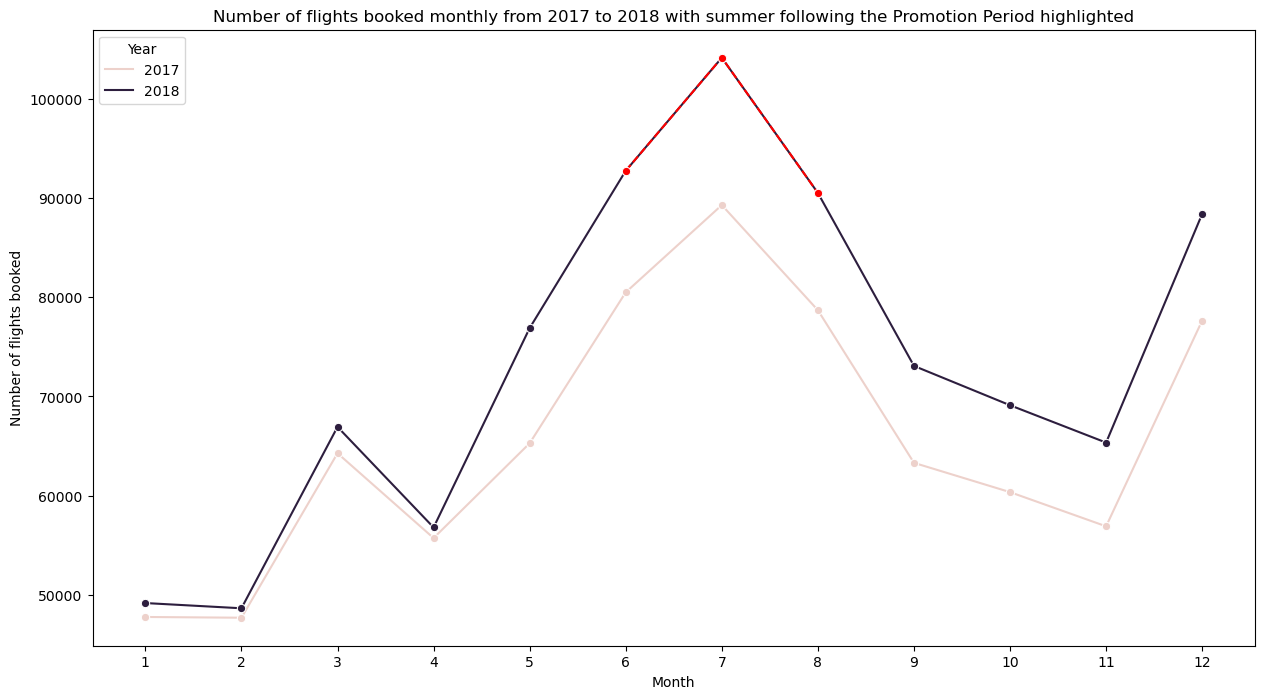

In [35]:
# Setting a colorblind-friendly palette for plotting
sns.set_palette("colorblind")

# Plotting enrollments for all years with the promotion period highlighted
plt.figure(figsize=(15, 8))

# Plot all lines
sns.lineplot(data=flights_booked_plot, x='Month', y='Number of Flights per month', hue='Year', marker='o')

# Highlight the summer following the promotion period
summer2018 = flights_booked_plot[flights_booked_plot['Promotion'] == '2018 Promotion']
sns.lineplot(data=summer2018, x='Month', y='Number of Flights per month', color='red', marker='o', linestyle='--')

plt.title('Number of flights booked monthly from 2017 to 2018 with summer following the Promotion Period highlighted')
plt.xlabel('Month')
plt.ylabel('Number of flights booked')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left')
plt.show()


**Notes:**
* The number of flights booked in 2018 generally follow the trend of 2017.
* The flights booked by members increase during summer months (June, and July) and in December and March
* The gap between the number of flights booked in 2018 increases following the promotional campaign.
* Further statistical tests are needed to assess the significance of the differences.

###### Anova test to compare the number of flights booked in summer of 2017 vs 2018

Null hypothesis: There is no significant difference in the average number of flights booked by an individual per month during the summer across different combinations of 'Month' and 'Year'.
Alternate hypothesis: There is a significant difference in the average number of flights booked by an individual per month during the summer across different combinations of 'Month' and 'Year'.

Post-hoc tests can be used to assess whether the mean number of flights booked by an individual per month during the summer following the promotional campaign is greater than the summer months of 2017.

In [36]:
selected_months = flight_bookings[flight_bookings['Month'].isin([6, 7, 8])]

selected_months.rename(columns={'Flights Booked': 'Flights_Booked'}, inplace=True)

selected_months['Month'] = pd.Categorical(selected_months['Month'])
selected_months['Year'] = pd.Categorical(selected_months['Year'])

In [37]:
# Fit Two-Way ANOVA model
model = ols('Flights_Booked ~ Month * Year', data=selected_months).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display results
print(anova_table)

                  sum_sq        df           F        PR(>F)
Month       9.968332e+03       2.0  120.000205  8.833871e-53
Year        1.494609e+04       1.0  359.846223  4.189475e-80
Month:Year  1.593212e+02       2.0    1.917931  1.469159e-01
Residual    4.211613e+06  101400.0         NaN           NaN


In [38]:


# Perform Tukey's HSD post hoc test
interaction = pd.MultiIndex.from_frame(selected_months[['Month', 'Year']])
tukey_results = pairwise_tukeyhsd(selected_months['Flights_Booked'], interaction)

print("\nTukey's HSD Post Hoc Test Results:")
print(tukey_results)


Tukey's HSD Post Hoc Test Results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
(6, 2017) (6, 2018)   0.7252    0.0  0.5254  0.9249   True
(6, 2017) (7, 2017)   0.5204    0.0  0.3206  0.7202   True
(6, 2017) (7, 2018)   1.3993    0.0  1.1995  1.5991   True
(6, 2017) (8, 2017)  -0.1066 0.6513 -0.3063  0.0932  False
(6, 2017) (8, 2018)   0.5928    0.0   0.393  0.7926   True
(6, 2018) (7, 2017)  -0.2048 0.0408 -0.4046  -0.005   True
(6, 2018) (7, 2018)   0.6742    0.0  0.4744  0.8739   True
(6, 2018) (8, 2017)  -0.8317    0.0 -1.0315 -0.6319   True
(6, 2018) (8, 2018)  -0.1324 0.4095 -0.3321  0.0674  False
(7, 2017) (7, 2018)   0.8789    0.0  0.6792  1.0787   True
(7, 2017) (8, 2017)  -0.6269    0.0 -0.8267 -0.4272   True
(7, 2017) (8, 2018)   0.0724 0.9069 -0.1274  0.2722  False
(7, 2018) (8, 2017)  -1.5059    0.0 -1.7057 -1.3061   True
(7, 2018) (8, 2018) 

**Outcome:**
* According the post-hoc tests it is evident that the mean number of flights booked by an individual per month during summer following the promotional campaign in 2018 is greater than 2017.
* There is no difference between the mean number of flights booked per individual per month in June and August in 2018.
* The mean number of flights booked per individual per month is highest in July 2018.

### Random Forest model to predict loyalty programme cancellation

#### Correlation


In [39]:
Selected_cor_columns = ['Salary','CLV','Enrollment Date','Cancellation Date','Loyalty Period (Months)', 'Enrollment Year', 'Enrollment Month','Cancellation Year','Cancellation Month']
selected_cor = customer_history[Selected_cor_columns]

correlation = selected_cor.corr()

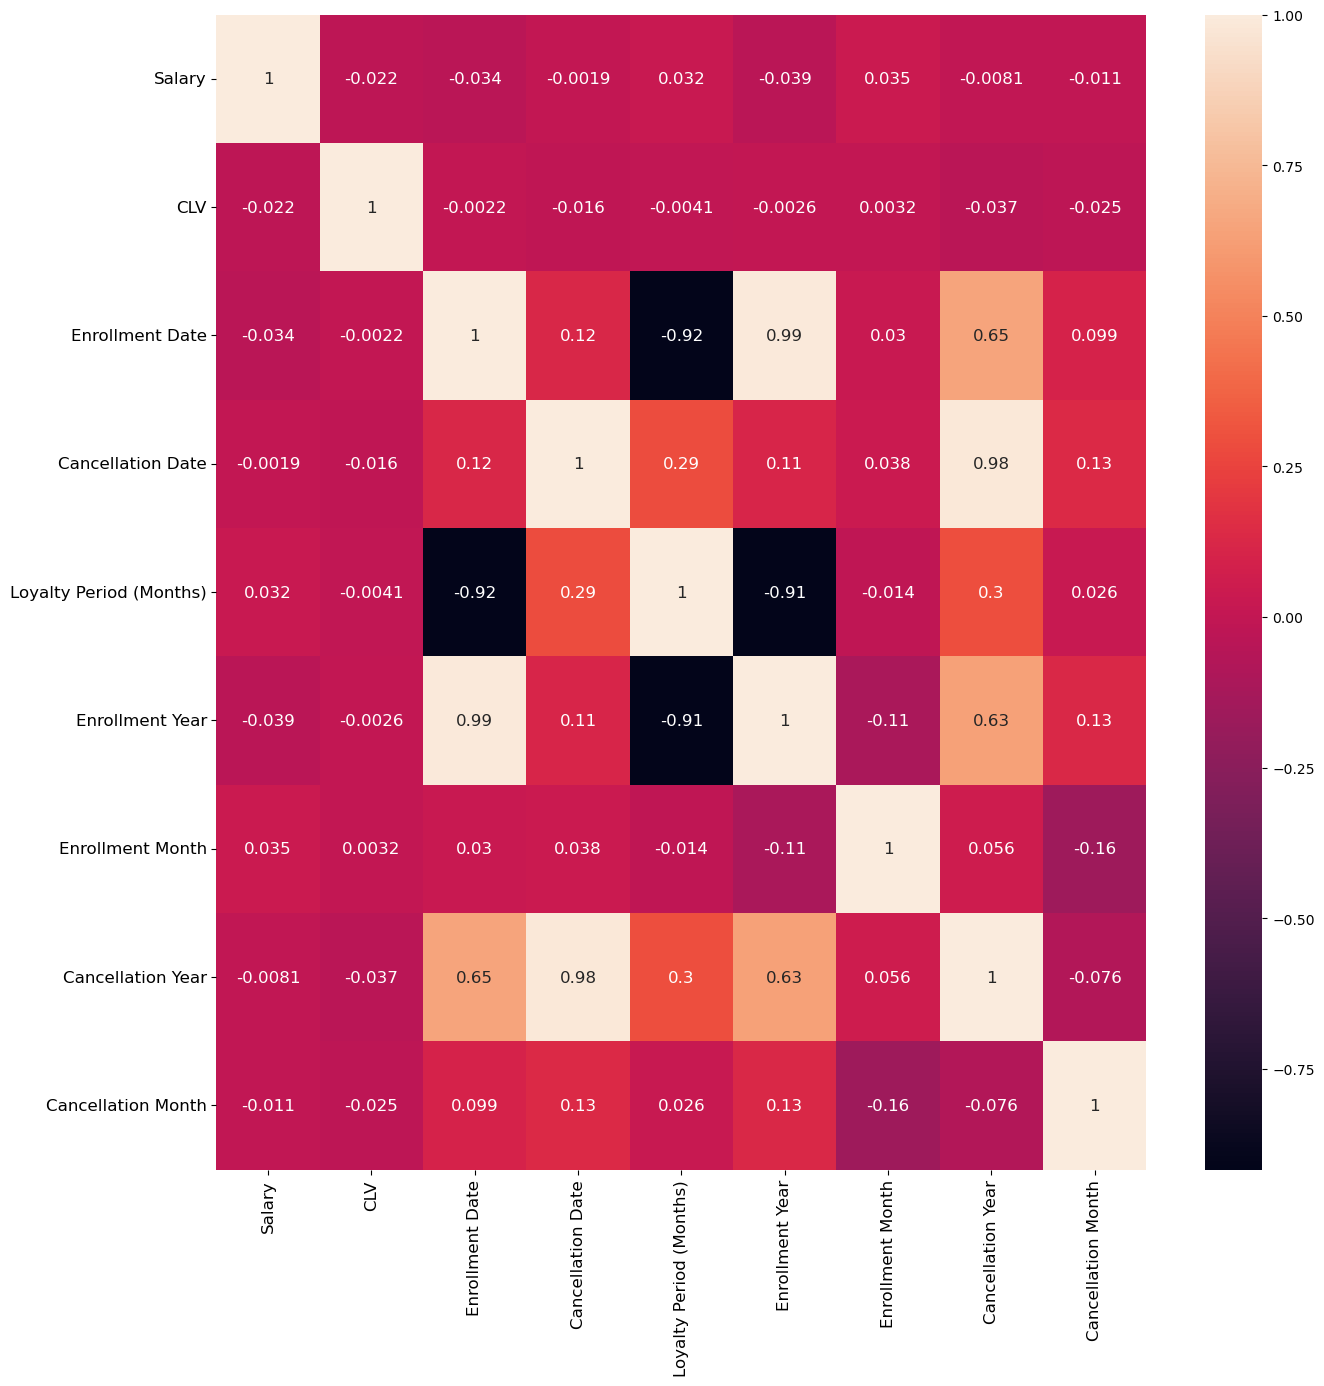

In [40]:
# Plot correlation
plt.figure(figsize=(15, 15))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Notes:**
* High negative correlation between Enrollment date and Loyalty Period - Customers enrolled recently lasts longer in the loyalty programme.
* Enrolment Date can be dropped for the model.
* Cancellation Date can replace Cancellation Year. Since datetime data types cannot be used in randomforests, Cancellation Year will be used.
* Enrollment and Cancellation Months can be retained as it is not closely correlated with other variables.

In [41]:
model_customer_history = customer_history.drop(columns=['Country','Enrollment Year', 'Cancellation Date','Enrollment Date', 'Cancellation Year','Cancellation Month'])
model_customer_history.head()

,Loyalty Number,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Month,Current Status,Loyalty Period (Months)
0,480934,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2,0,35
1,549612,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,3,0,34
2,429460,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,7,1,42
3,608370,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2,0,72
4,530508,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,10,0,51


In [42]:
customer_history
customer_history.to_csv('customer_history_updated.csv')

##### Transforming Categorical Data

In [43]:
def transform_categorical_columns(data, column_names):
    for col in column_names:
        # Transform into categorical type
        data[col] = data[col].astype('category')
        
        # Display the number of categories within this column
        print(f"Categories in {col}:")
        print(data[col].value_counts())
        
        # One-hot encoding using get_dummies
        data = pd.get_dummies(data, columns=[col], prefix=col)
    
    return data



In [44]:
columns_to_transform = ['Enrollment Type','Province', 'City','Postal Code','Gender','Education','Marital Status','Loyalty Card']
model_customer_history_transformed = transform_categorical_columns(model_customer_history, columns_to_transform)

# Display the updated DataFrame
model_customer_history_transformed

Categories in Enrollment Type:
Enrollment Type
Standard          15766
2018 Promotion      971
Name: count, dtype: int64
Categories in Province:
Province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64
Categories in City:
City
Toronto           3351
Vancouver         2582
Montreal          2059
Winnipeg           658
Whistler           582
Halifax            518
Ottawa             509
Trenton            486
Edmonton           486
Quebec City        485
Dawson Creek       444
Fredericton        425
Regina             409
Kingston           401
Tremblant          398
Victoria           389
Hull               358
West Vancouver     324
St. John's         258
Thunder Bay        256
Sudbury         

,Loyalty Number,Salary,CLV,Enrollment Month,Current Status,Loyalty Period (Months),Enrollment Type_2018 Promotion,Enrollment Type_Standard,Province_Alberta,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland,Province_Nova Scotia,Province_Ontario,Province_Prince Edward Island,Province_Quebec,Province_Saskatchewan,Province_Yukon,City_Banff,City_Calgary,City_Charlottetown,City_Dawson Creek,City_Edmonton,City_Fredericton,City_Halifax,City_Hull,City_Kelowna,City_Kingston,City_London,City_Moncton,City_Montreal,City_Ottawa,City_Peace River,City_Quebec City,City_Regina,City_St. John's,City_Sudbury,City_Thunder Bay,City_Toronto,City_Tremblant,City_Trenton,City_Vancouver,City_Victoria,City_West Vancouver,City_Whistler,City_Whitehorse,City_Winnipeg,Postal Code_A1C 6H9,Postal Code_B3C 2M8,Postal Code_B3J 9S2,Postal Code_C1A 6E8,Postal Code_E1A 2A7,Postal Code_E3B 2H2,Postal Code_G1B 3L5,Postal Code_H2T 2J6,Postal Code_H2T 9K8,Postal Code_H2Y 2W2,Postal Code_H2Y 4R4,Postal Code_H3J 5I6,Postal Code_H3T 8L4,Postal Code_H4G 3T4,Postal Code_H5Y 2S9,Postal Code_J8Y 3Z5,Postal Code_K1F 2R2,Postal Code_K1G 4Z0,Postal Code_K8T 5M5,Postal Code_K8V 4B2,Postal Code_M1R 4K3,Postal Code_M2M 6J7,Postal Code_M2M 7K8,Postal Code_M2P 4F6,Postal Code_M2Z 4K1,Postal Code_M3R 4K8,Postal Code_M5B 3E4,Postal Code_M5V 1G5,Postal Code_M8Y 4K8,Postal Code_M9K 2P4,Postal Code_P1J 8T7,Postal Code_P1L 8X8,Postal Code_P1W 1K4,Postal Code_P2T 6G3,Postal Code_P5S 6R4,Postal Code_R2C 0M5,Postal Code_R3R 3T4,Postal Code_R6Y 4T5,Postal Code_S1J 3C5,Postal Code_S6J 3G0,Postal Code_T3E 2V9,Postal Code_T3G 6Y6,Postal Code_T4V 1D4,Postal Code_T9G 1W3,Postal Code_T9O 2W2,Postal Code_U5I 4F1,Postal Code_V09 2E9,Postal Code_V10 6T5,Postal Code_V1E 4R6,Postal Code_V5R 1W3,Postal Code_V6E 3D9,Postal Code_V6E 3Z3,Postal Code_V6T 1Y8,Postal Code_V6V 8Z3,Postal Code_Y2K 6R0,Gender_Female,Gender_Male,Education_Bachelor,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Loyalty Card_Aurora,Loyalty Card_Nova,Loyalty Card_Star
0,480934,83236.0,3839.14,2,0,35,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True
1,549612,NaN,3839.61,3,0,34,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True
2,429460,NaN,3839.75,7,1,42,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [45]:
model_customer_history_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Columns: 116 entries, Loyalty Number to Loyalty Card_Star
dtypes: bool(110), float64(2), int32(2), int64(2)
memory usage: 2.4 MB


In [46]:
model_customer_history_transformed = model_customer_history_transformed.dropna()
model_customer_history_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12499 entries, 0 to 16736
Columns: 116 entries, Loyalty Number to Loyalty Card_Star
dtypes: bool(110), float64(2), int32(2), int64(2)
memory usage: 1.9 MB


#### Modeling

In [47]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Make a copy of our data
model_df = model_customer_history_transformed.copy()

model_df.to_csv('model_df.csv')

# Separate target variable from independent variables
y = model_df['Current Status']
X = model_df.drop(columns=['Loyalty Number', 'Current Status'])
print(X.shape)
print(y.shape)

(12499, 114)
(12499,)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9374, 114)
(9374,)
(3125, 114)
(3125,)


In [50]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [51]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [52]:
y_test.value_counts()

Current Status
0    2726
1     399
Name: count, dtype: int64

In [53]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 229
False positives: 11
True negatives: 2715
False negatives: 170

Accuracy: 0.94208
Precision: 0.9541666666666667
Recall: 0.5739348370927319


**Notes:**
* True Negatives: Out of all the instances where the model correctly predicted a negative outcome (not canceling loyalty membership), there are 2715 cases. This is a good outcome, indicating that the model is effective at correctly identifying clients who do not cancel their loyalty membership.
* False Negative: Looking at the false negatives, this is where we have predicted a client to not cancel their loyalty membership when, in fact, they did (canceling loyalty membership = 1).
* The model incorrectly predicted 173 instances as negative when they were actually positive. This is an area for improvement because these are cases where the model failed to identify clients who actually canceled their loyalty membership.
* Looking at false positives, this is where we have predicted a client to cancel their loyalty membership when they actually didn't cancel (canceling loyalty membership = 0). For this value, we can see there are 11 cases, which is great!
* The model incorrectly predicted 11 instances as positive when they were actually negative. While the number is relatively low, it's still important to minimize false positives, as they represent cases where the model wrongly identifies clients who do not cancel their loyalty membership as canceling.
* With the true positives, we can see that in total we have 226 clients that canceled their loyalty membership in the test dataset. However, we are only able to correctly identify 226 of those 226, which is very poor.
* Out of all the instances where the model correctly predicted a positive outcome (canceling loyalty membership = 1), there are 226 cases. This is a good outcome, indicating that the model is effective at correctly identifying clients who actually canceled their loyalty membership.
* Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story. Accuracy alone may not be a sufficient metric, especially when dealing with imbalanced datasets.
* Precision measures the accuracy of the positive predictions. A precision score of 0.9536 indicates that, of all instances predicted as positive, 95.36% are truly positive. It's a good score, but there is room for improvement.
* Recall measures the ability of the model to capture all the positive instances. A recall of 0.5664 means that the classifier is only capturing 56.64% of all actual positive cases. This is a concern and indicates that the model is not performing well in identifying clients who actually canceled their loyalty membership. Improving recall would be a priority.

##### Feature importance

In [54]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


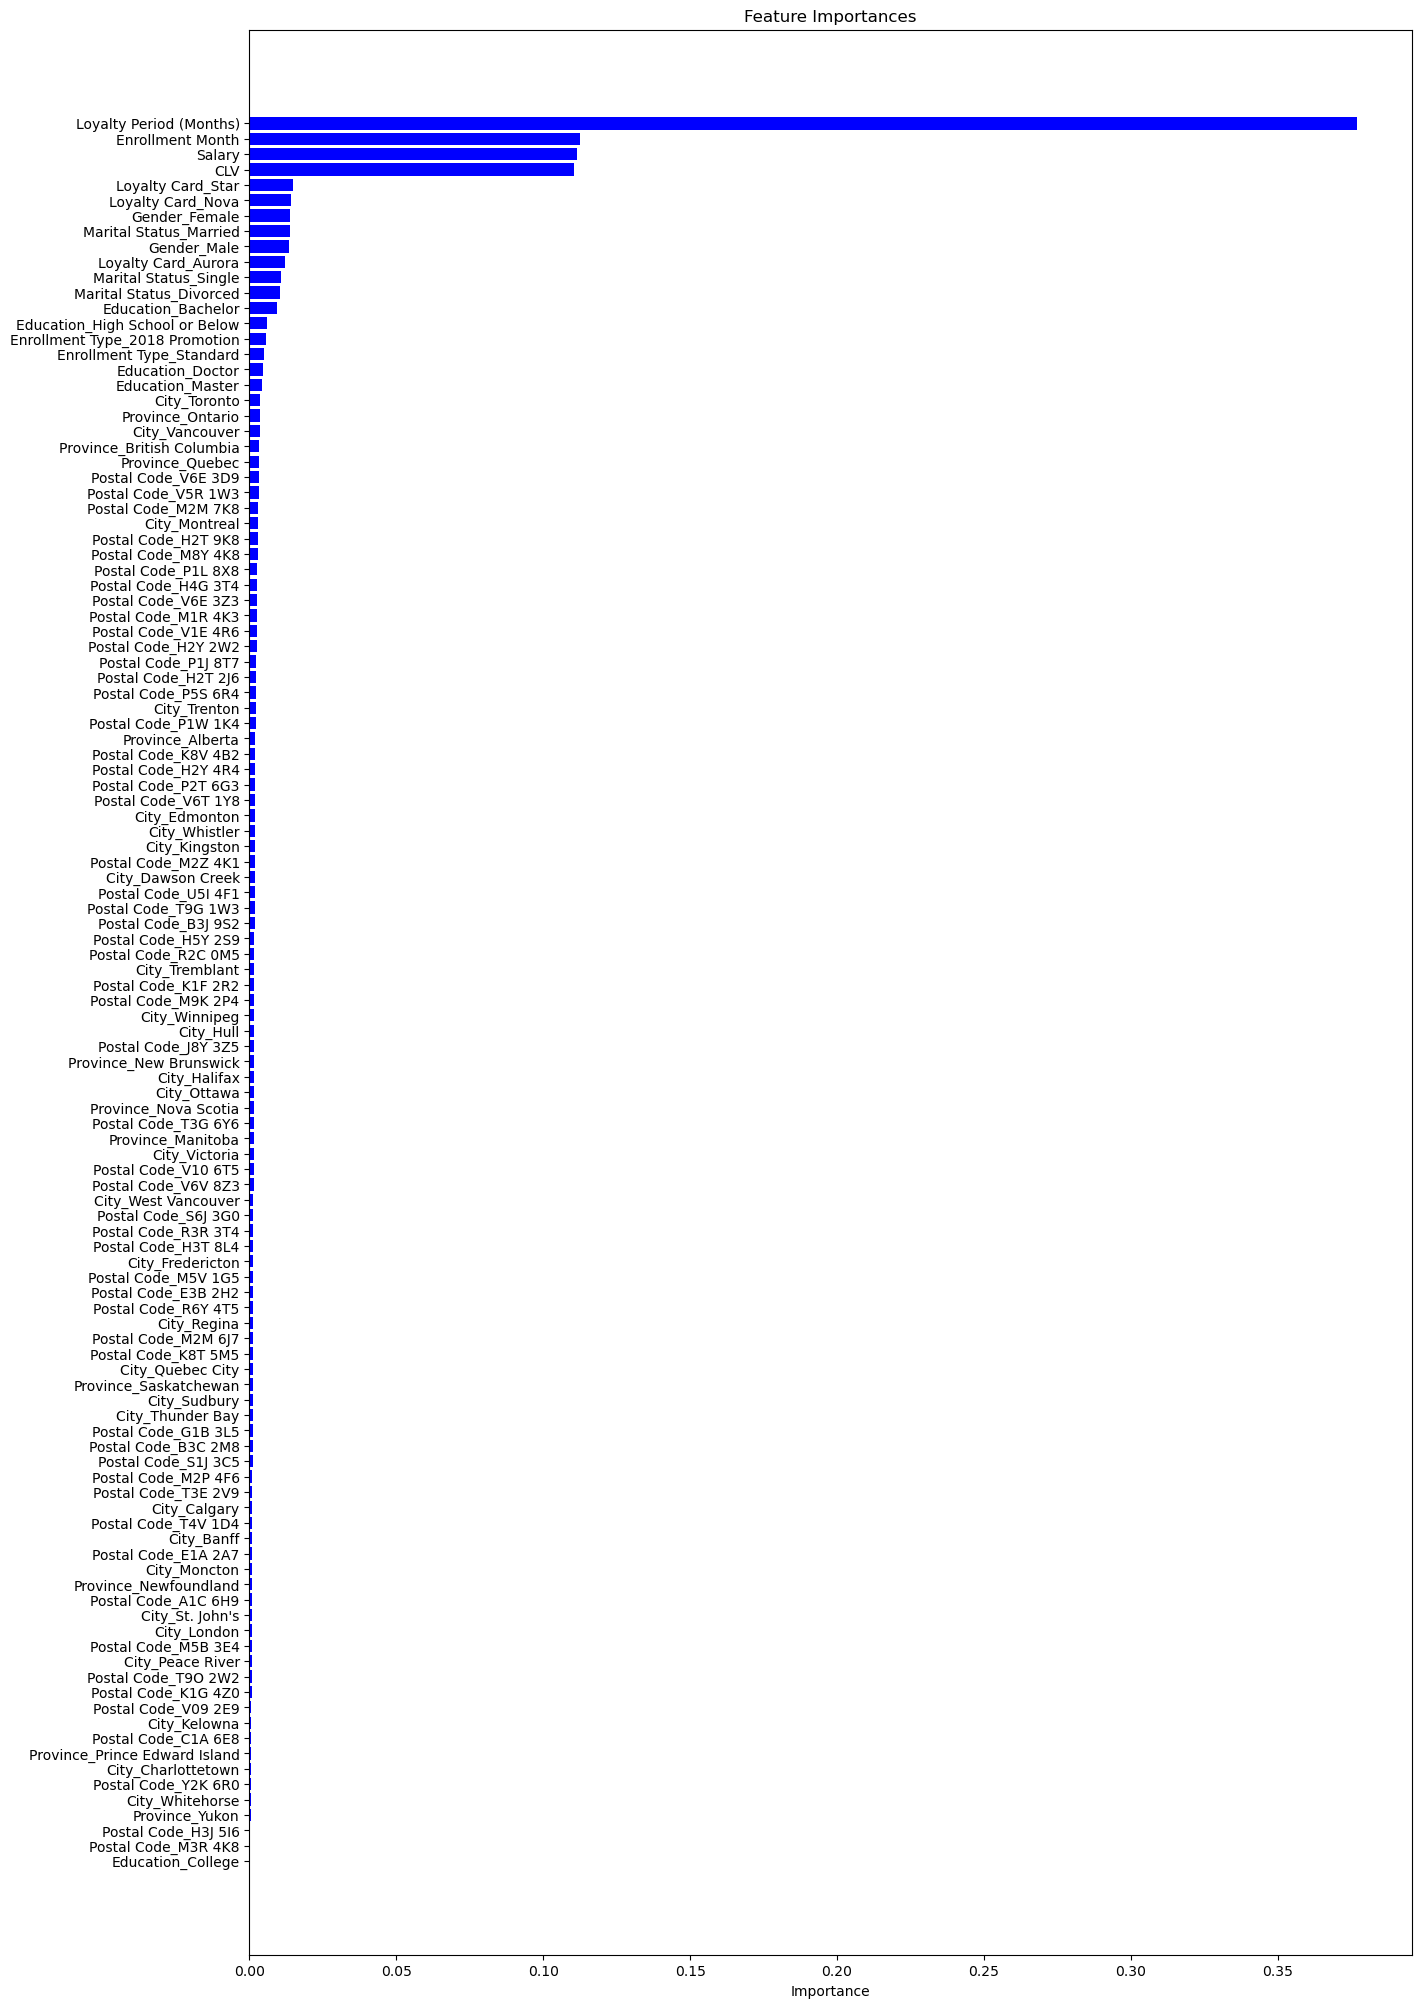

In [55]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [56]:
model_customer_history2 = customer_history.drop(columns=['Enrollment Type','Gender','Education','Marital Status','Loyalty Card','City','Province','Postal Code','Country','Enrollment Year', 'Cancellation Date','Enrollment Date', 'Cancellation Year','Cancellation Month'])
model_customer_history2.head()

,Loyalty Number,Salary,CLV,Enrollment Month,Current Status,Loyalty Period (Months)
0,480934,83236.0,3839.14,2,0,35
1,549612,NaN,3839.61,3,0,34
2,429460,NaN,3839.75,7,1,42
3,608370,NaN,3839.75,2,0,72
4,530508,103495.0,3842.79,10,0,51


In [57]:
#columns_to_transform2 = ['Enrollment Type']
#model_customer_history_transformed2 = transform_categorical_columns(model_customer_history2, columns_to_transform2)

# Display the updated DataFrame
model_customer_history_transformed2 = model_customer_history2

In [58]:
model_customer_history_transformed2 = model_customer_history_transformed2.dropna()
model_customer_history_transformed2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12499 entries, 0 to 16736
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loyalty Number           12499 non-null  int64  
 1   Salary                   12499 non-null  float64
 2   CLV                      12499 non-null  float64
 3   Enrollment Month         12499 non-null  int64  
 4   Current Status           12499 non-null  int32  
 5   Loyalty Period (Months)  12499 non-null  int32  
dtypes: float64(2), int32(2), int64(2)
memory usage: 585.9 KB


In [59]:
# Make a copy of our data
model2_df = model_customer_history_transformed2.copy()

model2_df.to_csv('model2_df.csv')

# Separate target variable from independent variables
y2 = model2_df['Current Status']
X2 = model2_df.drop(columns=['Loyalty Number', 'Current Status'])
print(X2.shape)
print(y2.shape)

(12499, 4)
(12499,)


In [60]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=42)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(9374, 4)
(9374,)
(3125, 4)
(3125,)


In [61]:
model2 = RandomForestClassifier(
    n_estimators=1000
)
model2.fit(X_train2, y_train2)

RandomForestClassifier(n_estimators=1000)

In [62]:
predictions2 = model2.predict(X_test2)
tn2, fp2, fn2, tp2 = metrics.confusion_matrix(y_test2, predictions2).ravel()

In [63]:
y_test2.value_counts()

Current Status
0    2726
1     399
Name: count, dtype: int64

In [64]:
print(f"True positives: {tp2}")
print(f"False positives: {fp2}")
print(f"True negatives: {tn2}")
print(f"False negatives: {fn2}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test2, predictions2)}")
print(f"Precision: {metrics.precision_score(y_test2, predictions2)}")
print(f"Recall: {metrics.recall_score(y_test2, predictions2)}")

True positives: 277
False positives: 8
True negatives: 2718
False negatives: 122

Accuracy: 0.9584
Precision: 0.9719298245614035
Recall: 0.6942355889724311


**Notes:**
* Recall has increased to 0.69. The model can now identify 62% of the customers that would cancel the loyalty memberships.

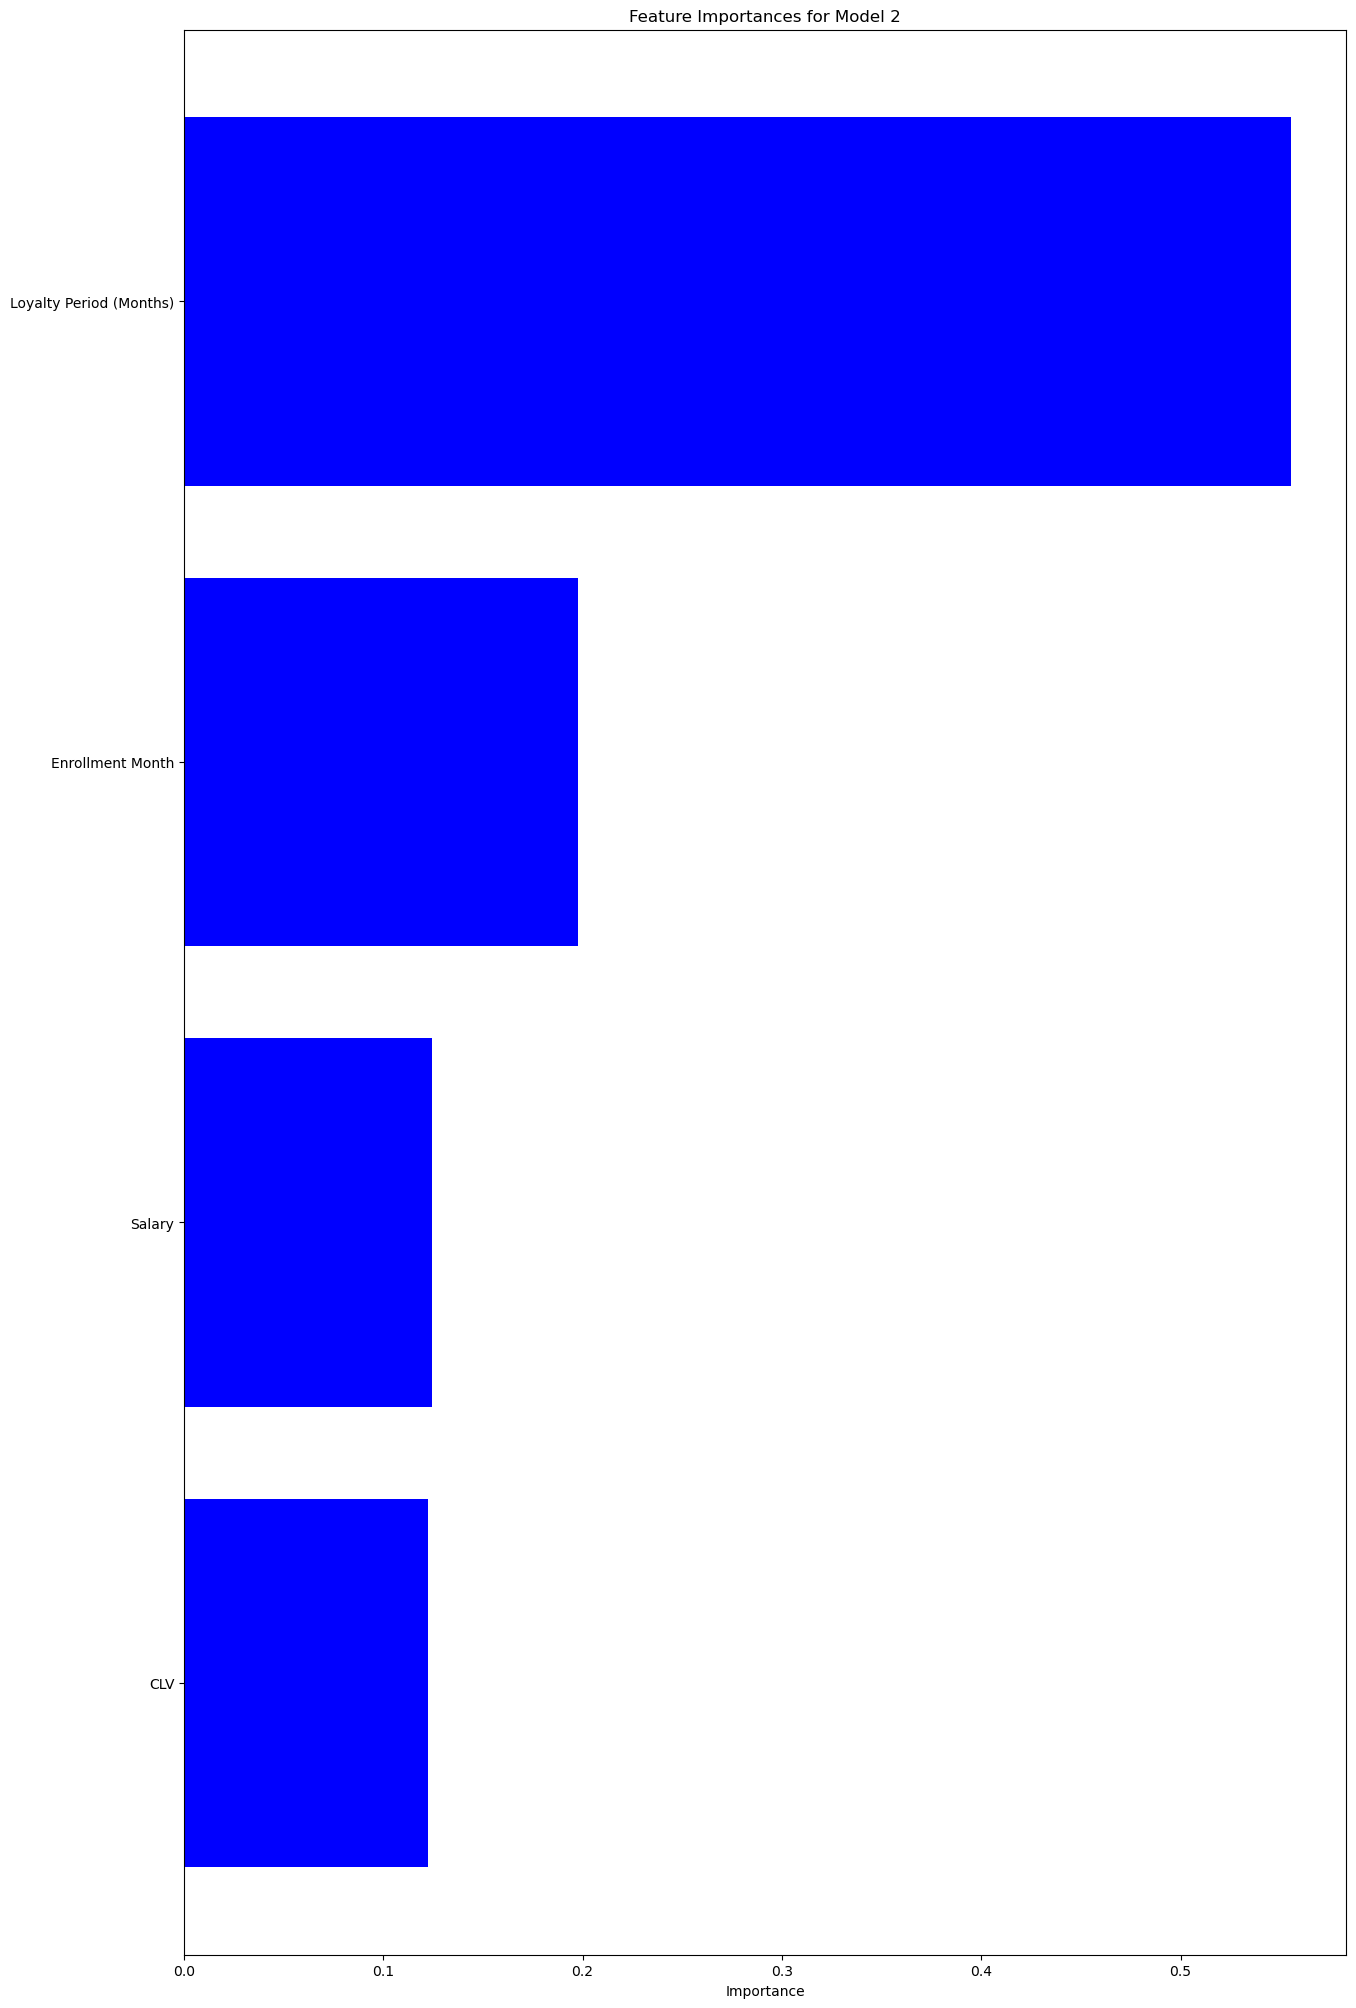

In [65]:
feature_importances2 = pd.DataFrame({
    'features': X_train2.columns,
    'importance': model2.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

plt.figure(figsize=(15, 25))
plt.title('Feature Importances for Model 2')
plt.barh(range(len(feature_importances2)), feature_importances2['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances2)), feature_importances2['features'])
plt.xlabel('Importance')
plt.show()

## Insights

1. **Provincial:**
   - The provinces of Ontario, British Columbia, and Quebec show higher enrollments overall. The promotional campaign appears to be particularly effective in these provinces, potentially indicating a targeted and successful outreach.

2. **City:**
   - Cities such as Toronto, Vancouver, and Montreal exhibit higher enrollments, suggesting that the promotional campaign has resonated well in these urban centers. Other cities, including Ottawa, Quebec City, Tremblant, Trenton, Victoria, and Whistler, also experienced increased enrollments.

3. **Gender:**
   - The promotional campaign has successfully reached both genders, indicating a balanced outreach effort that appeals to a diverse audience.

4. **Educational Background:**
   - Individuals with Bachelor's and College degrees show higher enrollments, aligning with the current highest educational levels. The campaign appears to have effectively reached individuals with these educational qualifications.

5. **Marital Status and Loyalty Card:**
   - The promotional campaign has reached individuals across all levels of marital status and loyalty card options, reflecting a broad and inclusive marketing strategy.

6. **Seasonal Impact on Enrollments:**
   - The promotional campaign has notably increased enrollments in the months of February, March, and April in 2018 compared to previous years. This seasonal impact suggests that the campaign has effectively captured attention during specific periods.

7. **Flight activity:**
   - The overall trend in the number of flights booked in 2018 follows a similar pattern to 2017. Flights booked by members tend to increase during summer months (June and July) and in December and March.

8. **Promotional Campaign Impact on Flights Booked:**
   - The gap between the number of flights booked in 2018 increases following the promotional campaign. However, further statistical tests are needed to assess the significance of these differences.

9. **Statistical Tests and Post-Hoc Analysis:**
   - According to post-hoc tests, the mean number of flights booked per individual per month during the summer following the promotional campaign in 2018 is greater than in 2017. Notably, there is no significant difference between the mean number of flights booked in June and August in 2018.

10. **Loyalty Membership Cancellation:**
    - Most customers tend to cancel their loyalty membership either shortly after joining or after approximately 8 months. The cancellation rate after a year is low, suggesting a level of sustained engagement beyond the initial period.
    - Factors affecting cancellations include Salary, Enrolled month, how long they have been in the loyalty programme and customer lifetime value.

In summary, the analysis provides valuable insights into the effectiveness of the promotional campaign, its impact on enrollments and flights booked, as well as patterns in loyalty membership cancellations. These insights can guide further strategic decisions and targeted improvements in the marketing approach.
